# 데이터 불러오기

In [8]:
import pandas as pd
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [9]:
# 런타임 다시 시작 후 실행
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

In [10]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

# 전처리

In [11]:
missing_counts = train.isna().sum()
missing_cols = missing_counts[missing_counts > 0].index
missing_cols

Index(['전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수'], dtype='object')

In [12]:
# 결측치 개수에 따른 컬럼 추가
train['missing_count'] = train.isnull().sum(axis=1)
test['missing_count'] = test.isnull().sum(axis=1)

## 중개사무소

In [13]:
agency_counts = train['중개사무소'].value_counts()

train['중개사무소_Count'] = train['중개사무소'].map(agency_counts)

test['중개사무소_Count'] = test['중개사무소'].apply(
    lambda x: agency_counts[x] if x in agency_counts else 0
)

train.drop(columns={'중개사무소'},inplace=True)
test.drop(columns={'중개사무소'},inplace=True)

## 결측치 대치

In [14]:
X_train = train.drop(columns = ['허위매물여부'])
y_train = train['허위매물여부']
df = pd.concat([X_train, test])

In [15]:
# '총층' 결측치 채우기 (평균값으로 대체)
df['총층'] = df['총층'].fillna(df['총층'].mean())

# '총층' > '해당층' 예측
train_data = df.dropna(subset=['총층', '해당층'])
X = train_data[['총층']].values
y = train_data['해당층'].values

if df['해당층'].isna().sum() > 0:
    model = LinearRegression()
    model.fit(X, y)
    missing_index = df['해당층'].isna()
    X_missing = df.loc[missing_index, ['총층']].values
    df.loc[missing_index, '해당층'] = np.round(model.predict(X_missing))

# '총층' > '총주차대수' 예측
train_data = df.dropna(subset=['총층', '총주차대수'])
X = train_data[['총층']].values
y = train_data['총주차대수'].values

if df['총주차대수'].isna().sum() > 0:
    model = LinearRegression()
    model.fit(X, y)
    missing_index = df['총주차대수'].isna()
    X_missing = df.loc[missing_index, ['총층']].values
    df.loc[missing_index, '총주차대수'] = np.round(model.predict(X_missing))

# '방수' 결측치 채우기 (평균값)
df['방수'] = df['방수'].fillna(df['방수'].mean())

# '방수' > '욕실수' 예측
train_data = df.dropna(subset=['방수', '욕실수'])
X = train_data[['방수']].values
y = train_data['욕실수'].values

if df['욕실수'].isna().sum() > 0:
    model = LinearRegression()
    model.fit(X, y)
    missing_index = df['욕실수'].isna()
    X_missing = df.loc[missing_index, ['방수']].values
    df.loc[missing_index, '욕실수'] = np.round(model.predict(X_missing))

# '방수' > '전용면적' 예측
train_data = df.dropna(subset=['방수', '전용면적'])
X = train_data[['방수']].values
y = train_data['전용면적'].values

if df['전용면적'].isna().sum() > 0:
    model = LinearRegression()
    model.fit(X, y)
    missing_index = df['전용면적'].isna()
    X_missing = df.loc[missing_index, ['방수']].values
    df.loc[missing_index, '전용면적'] = model.predict(X_missing)


# 결측치 현황 확인
missing_counts = df.isna().sum()
missing_counts

ID               0
매물확인방식           0
보증금              0
월세               0
전용면적             0
해당층              0
총층               0
방향               0
방수               0
욕실수              0
주차가능여부           0
총주차대수            0
관리비              0
제공플랫폼            0
게재일              0
missing_count    0
중개사무소_Count      0
dtype: int64

## 게재일 년,월 변환

In [16]:
df['게재일'] = pd.to_datetime(df['게재일'], errors='coerce')
df['월'] = df['게재일'].dt.month
def map_season(month):
    if month in [3, 4, 5]:
        return 3  # 봄
    elif month in [6, 7, 8]:
        return 2  # 여름
    elif month in [9, 10, 11]:
        return 1  # 가을
    else:
        return 0  # 겨울

# 계절 매핑 적용
df['계절'] = df['월'].apply(map_season)
df.drop(columns={'월'},inplace=True)

In [17]:
df['게재일'] = pd.to_datetime(df['게재일'], errors='coerce')
df['경과월'] = df['게재일'].dt.to_period('M')
df['경과월'] = df['경과월'].rank(method='dense', ascending=True).astype(int)
#df.drop(columns={'년', '월'},inplace=True)

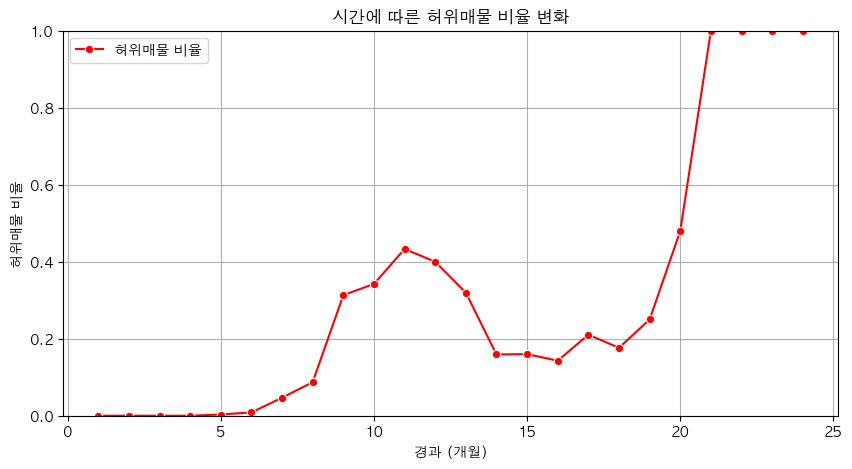

In [18]:
import matplotlib.pyplot as plt

time = train.copy()
time['게재일'] = pd.to_datetime(time['게재일'], errors='coerce')
time['경과'] = time['게재일'].dt.to_period('M')
time['경과'] = time['경과'].rank(method='dense', ascending=False).astype(int)
# 경과 컬럼별 허위매물 비율 계산
fraud_ratio = time.groupby('경과')['허위매물여부'].mean()

# 선 그래프 (허위매물 비율 변화)
plt.figure(figsize=(10, 5))
sns.lineplot(x=fraud_ratio.index, y=fraud_ratio.values, marker='o', color='red', label='허위매물 비율')
plt.xlabel('경과 (개월)')
plt.ylabel('허위매물 비율')
plt.title('시간에 따른 허위매물 비율 변화')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

## 로그 변환

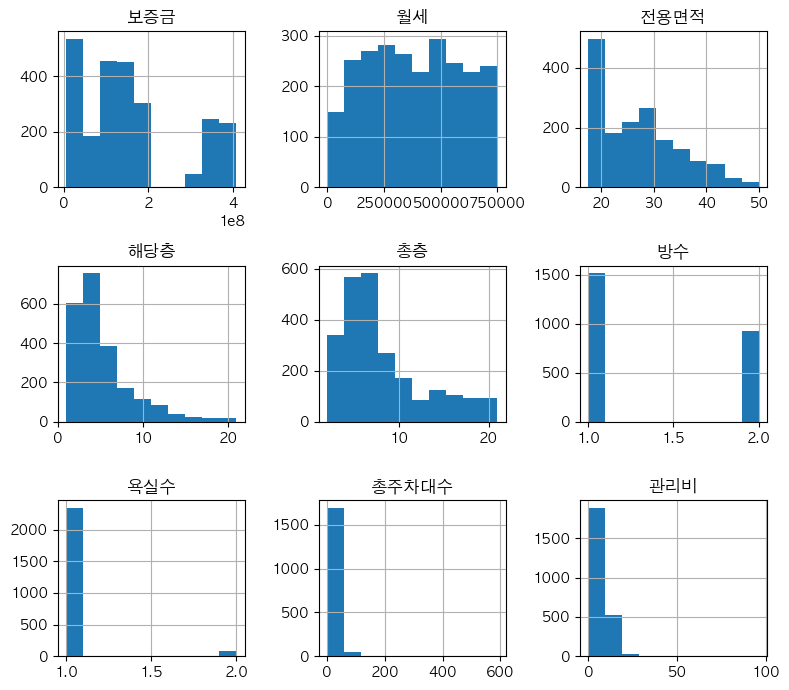

In [19]:
numeric = train[['보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수', '관리비']]

numeric.hist(figsize=(8,7))
plt.tight_layout()
plt.show()

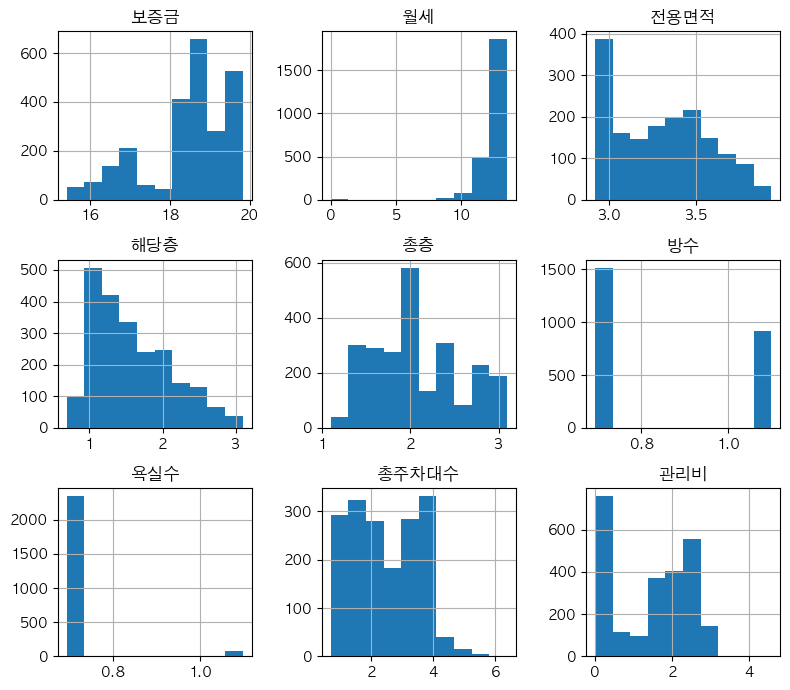

In [20]:
numeric_log = train[['보증금', '월세', '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수', '관리비']]

#로그변환
numeric_log = np.log(numeric_log + 1)

numeric_log.hist(figsize=(8,7))
plt.tight_layout()
plt.show()

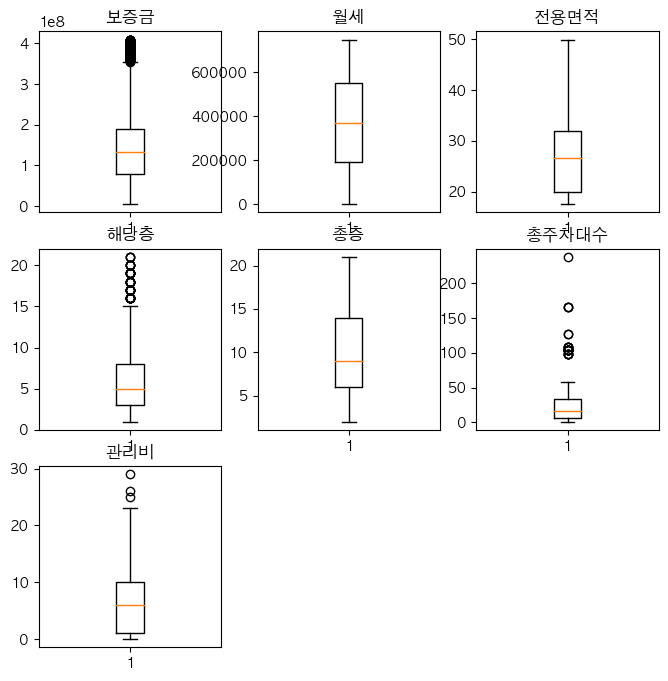

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))

numeric = numeric.dropna()

axs[0, 0].boxplot(numeric['보증금'])
axs[0, 0].set_title("보증금")

axs[0, 1].boxplot(numeric['월세'])
axs[0, 1].set_title("월세")

axs[0, 2].boxplot(numeric['전용면적'])
axs[0, 2].set_title("전용면적")

axs[1, 0].boxplot(numeric['해당층'])
axs[1, 0].set_title("해당층")

axs[1, 1].boxplot(numeric['총층'])
axs[1, 1].set_title("총층")

axs[1, 2].boxplot(numeric['총주차대수'])
axs[1, 2].set_title("총주차대수")

axs[2, 0].boxplot(numeric['관리비'])
axs[2, 0].set_title("관리비")

axs[2, 1].axis("off")
axs[2, 2].axis("off")

plt.show()

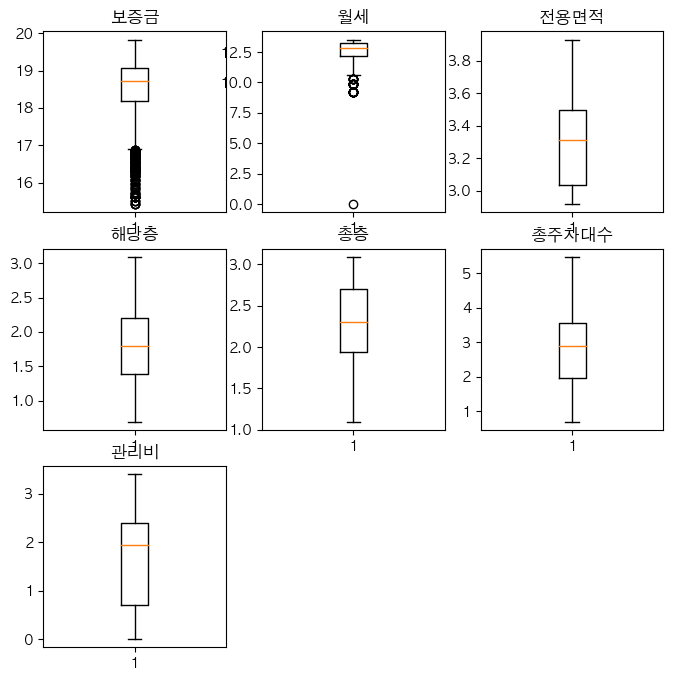

In [22]:
fig, axs = plt.subplots(3, 3, figsize=(8, 8))
numeric_log = numeric_log.dropna()

axs[0, 0].boxplot(numeric_log['보증금'])
axs[0, 0].set_title("보증금")

axs[0, 1].boxplot(numeric_log['월세'])
axs[0, 1].set_title("월세")

axs[0, 2].boxplot(numeric_log['전용면적'])
axs[0, 2].set_title("전용면적")

axs[1, 0].boxplot(numeric_log['해당층'])
axs[1, 0].set_title("해당층")

axs[1, 1].boxplot(numeric_log['총층'])
axs[1, 1].set_title("총층")

axs[1, 2].boxplot(numeric_log['총주차대수'])
axs[1, 2].set_title("총주차대수")

axs[2, 0].boxplot(numeric_log['관리비'])
axs[2, 0].set_title("관리비")

axs[2, 1].axis("off")
axs[2, 2].axis("off")

plt.show()

In [23]:
df[['해당층', '총층', '총주차대수', '관리비']] = np.log(df[['해당층', '총층', '총주차대수', '관리비']] + 1)

## 인코딩

In [24]:
df = pd.get_dummies(df, columns=['매물확인방식', '주차가능여부','방향'], drop_first=True)

# 변환할 컬럼만 int로 변경S
cols_to_convert = [col for col in df.columns if col.startswith(('매물확인방식_', '주차가능여부_','방향_'))]
df[cols_to_convert] = df[cols_to_convert].astype(int)

In [25]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 라벨 인코딩할 컬럼 리스트
label_cols = ['제공플랫폼']

# 각 컬럼에 대해 라벨 인코딩 적용
label_encoders = {col: LabelEncoder() for col in label_cols}
for col in label_cols:
    df[col] = label_encoders[col].fit_transform(df[col])

## 불필요 컬럼 삭제

In [26]:
df.drop(columns=['게재일', 'ID'],inplace=True)

## 표준화

In [27]:
X_train = df.iloc[:len(train)]
X_test = df.iloc[len(train):]

In [28]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 컬럼 이름을 문자열로 변환
X_train.columns = X_train.columns.astype(str)

# SMOTE로 데이터 증강 -> data 불균형 문제 해결 위함
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [29]:
from sklearn.preprocessing import StandardScaler

# Scaler 초기화
scaler = StandardScaler()

# 복사본 생성
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# 표준화할 열 목록
columns_to_scale = ['전용면적', '보증금', '월세', '관리비', '총주차대수', '해당층', '총층']

# X_train에 대해 표준화 수행
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

# X_test에 대해 표준화 수행 (훈련 데이터의 스케일러 사용)
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

# 모델링

In [ ]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score
import lightgbm as lgb
import numpy as np

# 1. SMOTEENN 적용 (학습 데이터에만 적용)
smoteenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smoteenn.fit_resample(X_train_scaled, y_train)

# 2. 모델 정의 (LightGBM)
lgb_model = lgb.LGBMClassifier(random_state=42)

# 3. 교차 검증 설정 (StratifiedKFold 사용)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. 평가 지표 정의 (F1-score를 사용)
scorer = make_scorer(f1_score, average='weighted')

# 5. 교차 검증 수행
cv_scores = cross_val_score(lgb_model, X_resampled, y_resampled, scoring=scorer, cv=skf, n_jobs=-1)

# 6. 결과 출력
print(f"Cross-Validation F1-Score (5-fold): {np.mean(cv_scores):.4f}")
print(f"각 Fold의 F1-Score: {cv_scores}")

In [30]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# LightGBM 모델을 사용한 10-fold 교차 검증
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose = -1)
lgb_predictions = cross_val_predict(lgb_model, X_train_scaled, y_train, cv=10)

# LightGBM에 대한 classification report
print("\nLightGBM Classification Report:")
print(classification_report(y_train, lgb_predictions))

lgb_accuracy = accuracy_score(y_train, lgb_predictions)
lgb_f1score = f1_score(y_train, lgb_predictions, average='weighted')

print("\nLightGBM Accuracy:", lgb_accuracy)
print("LightGBM F1-score:", lgb_f1score)


LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2154
           1       0.98      0.97      0.97      2154

    accuracy                           0.97      4308
   macro avg       0.97      0.97      0.97      4308
weighted avg       0.97      0.97      0.97      4308


LightGBM Accuracy: 0.97330547818013
LightGBM F1-score: 0.973305154542852


## 변수 선택

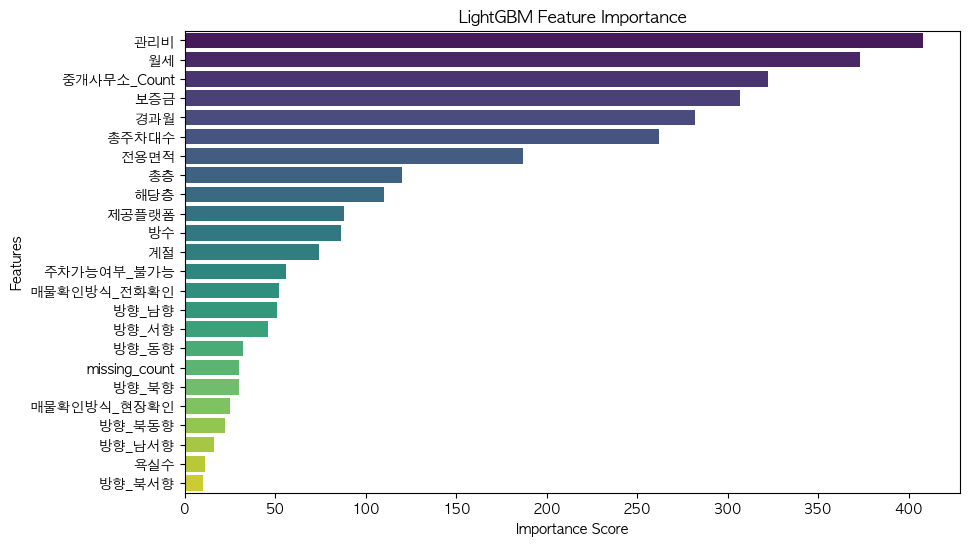

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# LightGBM 모델 학습
lgb_model = lgb.LGBMClassifier(n_estimators=100,  random_state=42, verbose=-1)
lgb_model.fit(X_train_scaled, y_train)

# Feature Importance 가져오기
feature_importance = lgb_model.feature_importances_
feature_names = X_train_scaled.columns

# 데이터프레임으로 변환 후 정렬
feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df, palette='viridis')
plt.title('LightGBM Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [32]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer

# 1. LightGBM 모델 정의 및 학습 (초기 모델 학습)
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# 피처 중요도 추출
importances = lgb_model.feature_importances_
features = X_train_scaled.columns

# 중요도와 피처 이름을 DataFrame으로 정렬
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 2. 피처 개수별로 성능 확인 (교차 검증)
best_score = 0
best_num_features = 0
best_selector = None
scores = {}

scorer = make_scorer(f1_score, average='weighted')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for num_features in range(5, len(features) + 1, 1):
    selected_features = importance_df['Feature'].iloc[:num_features]
    X_train_selected = X_train_scaled[selected_features]
    
    # 모델 학습 및 평가
    lgb_model = lgb.LGBMClassifier(random_state=42)
    score = np.mean(cross_val_score(lgb_model, X_train_selected, y_train, scoring=scorer, cv=skf))
    scores[num_features] = score

    if score > best_score:
        best_score = score
        best_num_features = num_features
        best_selector = selected_features

# 최적의 피처 개수 출력
print(f"최적의 피처 개수: {best_num_features}개")
print(f"최고 F1-score: {best_score:.4f}")

최적의 피처 개수: 12개
최고 F1-score: 0.9770


## 하이퍼파라미터 튜닝

In [28]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 범위 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

lgb_model = lgb.LGBMClassifier(random_state=42)
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, 
                           scoring='f1_weighted', cv=5, verbose=2, n_jobs=-1)

# 하이퍼파라미터 튜닝 수행
grid_search.fit(X_train_selected, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[LightGBM] [Info] Number of positive: 1723, number of negative: 1724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2150
[LightGBM] [Info] Number of data points in the train set: 3447, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499855 -> initscore=-0.000580
[LightGBM] [Info] Start training from score -0.000580
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   6.3s
[LightGBM] [Info] Number of positive: 1724, number of negative: 1723
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 3447, n

## 모델 학습

In [42]:
# 최적 하이퍼파라미터
best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 12,
    'n_estimators': 200,
    'subsample': 0.8,
    'random_state': 42
}

# 최적 변수 선택
num_features = 15

'''
best_params = {
    'colsample_bytree': 1.0, 
    'learning_rate': 0.05, 
    'max_depth': 8, 
    'n_estimators': 100, 
    'subsample': 0.8
}


best_params = {'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 12,
 'n_estimators': 100,
 'subsample': 0.8}
'''

"\nbest_params = {\n    'colsample_bytree': 1.0, \n    'learning_rate': 0.05, \n    'max_depth': 8, \n    'n_estimators': 100, \n    'subsample': 0.8\n}\n\n\nbest_params = {'colsample_bytree': 1.0,\n 'learning_rate': 0.1,\n 'max_depth': 12,\n 'n_estimators': 100,\n 'subsample': 0.8}\n"

In [43]:
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb
import pandas as pd

# 1. LightGBM 모델 정의 (사용자 지정 하이퍼파라미터)
lgb_model = lgb.LGBMClassifier(**best_params)

# 2. 모델 학습 (Feature Selection을 위한 초기 학습)
lgb_model.fit(X_train_scaled, y_train)

# 피처 중요도 추출
importances = lgb_model.feature_importances_
features = X_train_scaled.columns

# 중요도와 피처 이름을 DataFrame으로 정렬
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Feature Selection
selected_features = importance_df['Feature'].iloc[:num_features]
X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

# 선택된 피처 확인 (선택된 피처의 개수 출력)
print(f"선택된 피처 개수: {X_train_selected.shape[1]}")

# 4. 모델 학습 (Feature Selection 후 데이터로 학습)
lgb_model.fit(X_train_selected, y_train)

# 5. 예측 수행 (테스트 데이터)
y_pred = lgb_model.predict(X_test_selected)

선택된 피처 개수: 15


# 데이콘 제출

In [44]:
# 6. 제출 파일 생성
submission = pd.DataFrame({'ID': test['ID'], '허위매물여부': y_pred})
submission.to_csv('./submission.csv', index=False)